In [1]:
import dllHelper
dllHelper.loadDll("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin\\*.dll")

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.0
Num GPUs Available:  1


## Loading Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/255
y_train_1h = pd.get_dummies(pd.DataFrame(y_train)[0]).to_numpy()
print(x_train.shape, y_train.shape, y_train_1h.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (60000, 10) (10000, 784) (10000,)


In [4]:
m, n = x_train.shape
c = y_train_1h.shape[1]
p = 15
print(m, n, p, c)

60000 784 15 10


## Implementing Model in Tensorflow

In [5]:
beta1 = 0.9
beta2 = 0.999
def crossEntropySoftmax(softmaxScore, y1h):
    a = tf.multiply(softmaxScore, y1h)
    b = tf.reduce_sum(a,axis=1, keepdims=True)
    c = -tf.math.log(b)
    return c

def adamOptimizer(dxs, first_moments, second_moments, t):
    dxc = []
    fm = []
    sm = []
    for dx, first_moment, second_moment in zip(dxs, first_moments, second_moments):
        first_moment = beta1 * first_moment + (1-beta1) * dx
        second_moment = beta2 * second_moment + (1-beta2) * dx * dx
        first_unbias = first_moment / (1 - beta1 ** t)
        second_unbias = second_moment/ (1 - beta2 ** t)
        dxc.append(first_unbias / (tf.sqrt(second_unbias) + 1e-7))
        fm.append(first_moment)
        sm.append(second_moment)
    return dxc, fm, sm

In [6]:
x = tf.constant (x_train, dtype=tf.float32)
y = tf.constant(y_train_1h, dtype=tf.float32)

In [7]:
metric = tf.metrics.Accuracy()
initializer = tf.initializers.GlorotUniform()
w1 = tf.Variable(initializer(shape=(n,p)), dtype=tf.float32)
b1 = tf.Variable(initializer(shape=(1,p)), dtype=tf.float32)
w2 = tf.Variable(initializer(shape=(p,c)), dtype=tf.float32)
b2 = tf.Variable(initializer(shape=(1,c)), dtype=tf.float32)

In [15]:
lr = 0.01
itr = 10000
start_time = time.time()
prm = np.empty((1,3))

fm = [0,0,0,0]
sm = [0,0,0,0]

for i in range(itr+1):
    with tf.GradientTape() as g:
        g.watch([w1, b1, w2, b2])
        # Forward Pass
        z1 = tf.matmul(x, w1) + b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, w2) + b2
        a2 = tf.nn.softmax(z2)
        ce = crossEntropySoftmax(a2, y)
        loss = tf.reduce_mean(ce)
        dw1, db1, dw2, db2 = g.gradient(loss, [w1, b1, w2, b2])
        
        #Adam Optimizer
        
        (dw1, db1, dw2, db2) , fm, sm = adamOptimizer([dw1, db1, dw2, db2], fm, sm, i+1)
        
        #Gradient Update
        w1.assign_sub(lr*dw1)
        b1.assign_sub(lr*db1)
        w2.assign_sub(lr*dw2)
        b2.assign_sub(lr*db2)

        #Accuracy
        metric.update_state(tf.argmax(y, 1), tf.argmax(a2,1))
        acc = metric.result().numpy()
        prm = np.append(prm, [[i,loss.numpy(), acc]], axis=0)
        
        #Printing Parameters
        if i%(itr/10) ==0:
            print(i, " Loss:",loss.numpy(), " Accuracy:",acc)
end_time = time.time()
print("Complete!!!", " Loss:",loss.numpy(), " Accuracy:",acc)
print("Time Elapsed:" , (end_time - start_time)/60, "Minutes")

0  Loss: 0.066868514  Accuracy: 0.9685296
1000  Loss: 0.06274001  Accuracy: 0.9715861
2000  Loss: 0.057282083  Accuracy: 0.9739919
3000  Loss: 0.053165372  Accuracy: 0.97583765
4000  Loss: 0.04950071  Accuracy: 0.9773486
5000  Loss: 0.048277494  Accuracy: 0.978606
6000  Loss: 0.04540297  Accuracy: 0.9796627
7000  Loss: 0.051878266  Accuracy: 0.9805189
8000  Loss: 0.04505042  Accuracy: 0.9812626
9000  Loss: 0.04076171  Accuracy: 0.9819246
10000  Loss: 0.041321475  Accuracy: 0.98251677
Complete!!!  Loss: 0.041321475  Accuracy: 0.98251677
Time Elapsed: 8.772208515803019 Minutes


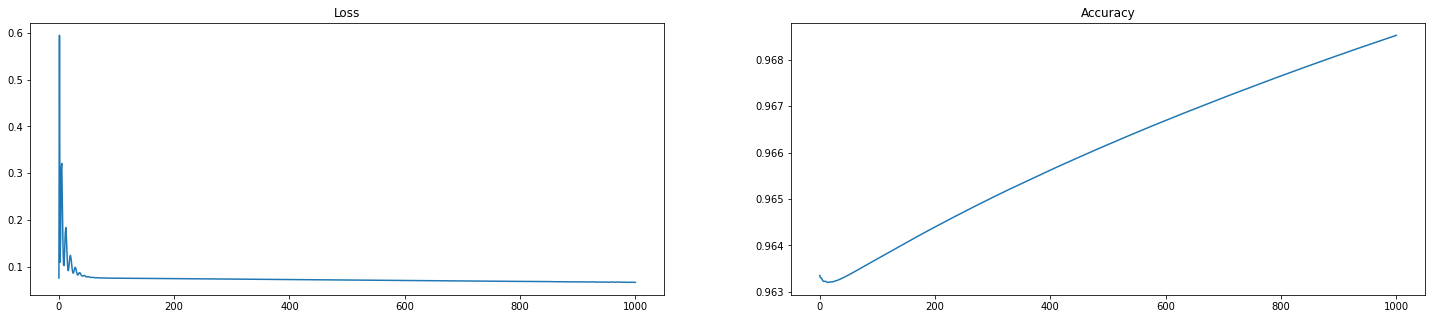

In [14]:
plt.figure(figsize=(25, 5))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(prm[1:,0], prm[1:,1])
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(prm[1:,0], prm[1:,2])
plt.show()